In [158]:
# Imports
import scipy
from scipy.signal import windows, welch
from scipy.signal.windows import dpss
from scipy.fft import fft, fftfreq
import numpy as np
import math
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import seaborn as sns

# Generating Data

In [159]:
def generate_data(random_state = 42):
    data = spectrum(
        sampling_rate=1000,
        duration=30,
        aperiodic_exponent=2.0,
        aperiodic_offset=2.0,
        knee=200,
        peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
        average_firing_rate=0.0,
        random_state=random_state,
        direct_estimate=True
    )
    return data

data = generate_data()
data_td = data.time_domain.combined_signal
data_fd = data.frequency_domain

# Single Taper (Welch)

In [160]:
def single_taper_welch(signal, window_length, taper_shape, fs=1000):
    """
    Args: 
    - signal: signal, time domain 
    - window_length: in seconds
    - taper_shape: string, desired taper
    - fs: sampling frequency, default = 1000

    Returns:
    - freqs: positive frequencies
    - psd: estimated power spectral density for positive frequencies (doubled)
    """
    nperseg = int(window_length * fs) # number of samples per segment

    freqs, psd = welch(signal,
                       fs=fs,
                       window=taper_shape,
                       nperseg=nperseg,
                       noverlap=0,
                       scaling='density' # return psd
                       )

    return freqs, psd

# Single Taper (No Welch)

In [161]:
# def u_scaling(fft_result_single, taper_shape, N): # https://www.mathworks.com/help/signal/ug/nonparametric-methods.html#f12-16152 
#     # Scale the FFT results for single taper
#     window = windows.get_window(taper_shape, N)
#     U = 1/N * sum(i**2 for i in window)
#     scaled_fft_single = [i/U for i in np.abs(fft_result_single)]
#     return scaled_fft_single

def single_taper_no_welch(signal, window_length, taper_shape, fs=1000):
    """
    Args: 
    - signal: signal, time domain 
    - window_length: in seconds
    - taper_shape: string, desired taper
    - fs: sampling frequency, default = 1000

    Returns:
    - freqs: positive frequencies
    - psd: estimated power spectral density for positive frequencies (doubled)
    """
    
    N = int(window_length * fs)  # number of samples in window
    x = signal[-N:] # retrive last chunk
    window = windows.get_window(taper_shape, N)
    U = (1/N) * np.sum(window ** 2)

    tapered = x * window
    fft_result = np.fft.rfft(tapered, n = N) # rfft only returns nonnegative frequencies
    psd = (np.abs(fft_result)**2) / (fs * N * U)

    # double the power except for 0
    psd[1:] *= 2

    freqs = np.fft.rfftfreq(N, d=1/fs)

    # drop nyquist if present; only true if N is even
    if freqs[-1] == fs / 2:
        freqs = freqs[:-1]
        psd = psd[:-1]

    return freqs, psd

# Multitaper

In [162]:
def multitaper(signal, window_length, fs=1000, TW=1, K=None): # only TW and Window length
    """
    Args: 
    - signal: time domain 
    - window_length: size of window (in s)
    - fs: sampling frequency, default = 1000
    - TW: time bandwidth, default = 1
    - K: number of tapers, default = 1

    Returns:
    - freqs: positive frequencies
    - psd: estimated power spectral density for positive frequencies (doubled)
    """

    N = int(window_length * fs)  # number of samples in window
    x = signal[-N:] # retrieve last chunk

    # default to 2*NW - 1 tapers
    if K is None:
        K = int(2 * TW - 1)

    # create dpss tapers
    tapers = dpss(N, TW, K)  # shape: (K, N)

    psd_tapers = []
    freqs = np.fft.rfftfreq(N, d=1/fs)

    for k in range(K):
        taper = tapers[k]
        U = (1/N) * np.sum(taper**2) # normalization for each taper
        tapered = x * taper
        fft_result = np.fft.rfft(tapered)
        psd_k = (np.abs(fft_result)**2) / (fs * N * U)
        psd_tapers.append(psd_k)
    
    psd = np.mean(psd_tapers, axis=0) # take average of all tapers

    # drop nyquist if present; only true if N is even
    if freqs[-1] == fs / 2:
        freqs = freqs[:-1]
        psd = psd[:-1]


    return freqs, psd

# Example Run

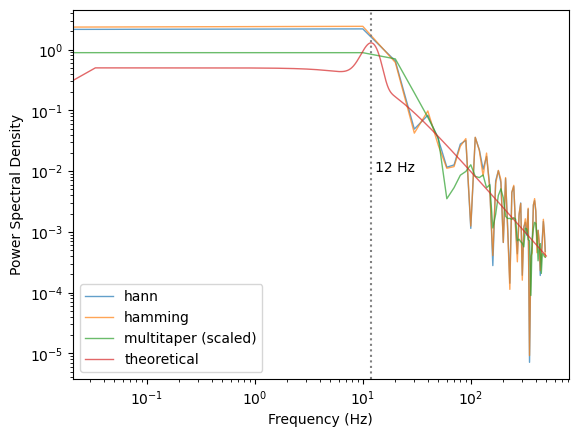

In [163]:
window_length = 0.1 # change window length

freq_hann, psd_hann = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hann')
freq_hamming, psd_hamming = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hamming')
freq_mt, psd_mt = multitaper(data_td, window_length=window_length, TW=2)

plt.loglog(freq_hann, psd_hann, linewidth=1, alpha=0.7, label='hann')
plt.loglog(freq_hamming, psd_hamming, linewidth=1, alpha=0.7, label='hamming')
plt.loglog(freq_mt, psd_mt, linewidth=1, alpha=0.7, label='multitaper (scaled)')
plt.plot(data_fd.frequencies, data_fd.combined_spectrum, linewidth=1, alpha=0.7, label='theoretical')

plt.axvline(x=12, color='gray', linestyle=':', linewidth=1.5)
plt.text(13, 0.01,'12 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()

# Bias

In [164]:
# Calculate Bias

def calc_mean_bias(empiricalPSD, theoreticalPSD):
    N = len(theoreticalPSD)
    empiricalPSD = empiricalPSD[:-1] if (len(empiricalPSD) > N) else empiricalPSD
    biases = np.abs(empiricalPSD - theoreticalPSD) # do we need to change this cuz the empirical length is 251 while theoretical length is 250
    meanBias = np.sum(biases)/N

    return meanBias

In [165]:
# def get_correct_theoretical_window(psd_theoretical_fd, freq_theoretical_fd, freq_empirical):
#     psd_theoretical_correct_window = np.empty(len(freq_empirical))
#     for i, freq in enumerate(freq_empirical):
#         matches = np.where(np.isclose(freq_theoretical_fd, freq, atol=1e-8))[0]
#         if matches.size > 0:
#             psd_theoretical_correct_window[i] = psd_theoretical_fd[matches[0]]
#         else:
#             psd_theoretical_correct_window[i] = np.nan  # TODO: find a better solution if no match
#             # I don't think this else should ever occur though.
#     return psd_theoretical_correct_window
def get_correct_theoretical_window(psd_theoretical_fd, freq_theoretical_fd, freq_empirical):
    """
    Interpolates theoretical PSD onto empirical frequency axis.
    """
    from scipy.interpolate import interp1d
    interpolator = interp1d(freq_theoretical_fd, psd_theoretical_fd, bounds_error=False, fill_value=np.nan)
    return interpolator(freq_empirical)

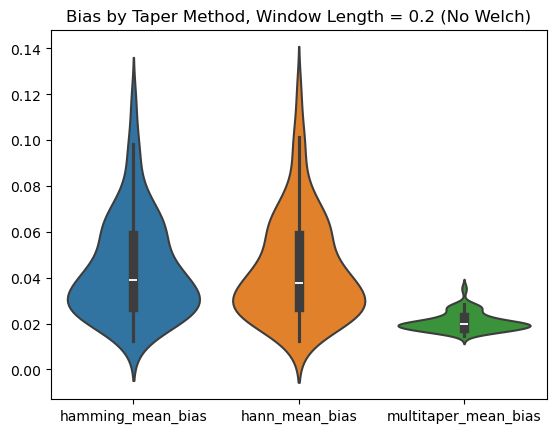

In [166]:
window_length = 0.2
TW = 1

df = pd.DataFrame(columns=['hamming_mean_bias', 'hann_mean_bias', 'multitaper_mean_bias'])
# compare with scipy periodogram and spectral connectivity multitaper
for random_state in range(100): # generate data multiple times

    data = generate_data(random_state=random_state)
    data_td = data.time_domain.combined_signal
    data_fd = data.frequency_domain
    
    freq_hann, psd_hann = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hann')
    freq_hamming, psd_hamming = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hamming')
    freq_mt, psd_mt = multitaper(data_td, window_length=window_length, TW=4)

    psd_theo = get_correct_theoretical_window(data_fd.combined_spectrum, data_fd.frequencies, freq_hamming)

    # Calculate bias for each taper
    df.loc[len(df)] = [
        calc_mean_bias(psd_hamming, psd_theo),
        calc_mean_bias(psd_hann, psd_theo),
        calc_mean_bias(psd_mt, psd_theo)
    ]

# violin plot
plt.title(f"Bias by Taper Method, Window Length = {window_length} (No Welch)")
sns.violinplot(data=df, linewidth=1.5)
plt.savefig(f'{window_length}s_multitaper_{TW*2-1}_singletaper_no_welch_bias.png')

# Making This More Generalized...

In [167]:
# window_length_options = [0.1, 0.5, 20] # seconds
# TW_options = [1, 2, 4] # time-bandwidth products

# for window_length in window_length_options:
#     for TW in TW_options:
#         fig, ax = plt.subplots(figsize=(10, 6))
#         df = pd.DataFrame(columns=['hamming_mean_bias', 'hann_mean_bias', 'multitaper_mean_bias'])
#         for random_state in range(100): # generate data multiple times

#             data = generate_data(random_state=random_state)
#             data_td = data.time_domain.combined_signal
#             data_fd = data.frequency_domain
            
#             freq_hann, psd_hann = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hann')
#             freq_hamming, psd_hamming = single_taper_no_welch(data_td, window_length=window_length, taper_shape='hamming')
#             freq_mt, psd_mt = multitaper(data_td, window_length=window_length, TW=TW)

#             psd_theoretical_correct_window = get_correct_theoretical_window(data_fd.combined_spectrum, data_fd.frequencies, psd_hamming)
#             df.loc[len(df)] = [calc_mean_bias(psd_hamming, psd_theoretical_correct_window),
#                             calc_mean_bias(psd_hann, psd_theoretical_correct_window), 
#                             calc_mean_bias(psd_mt, psd_theoretical_correct_window)]
#         plt.title(f"Bias by Taper Method, Window Length = {window_length}, Number of tapers = {TW*2-1} (No Welch)")
#         sns.violinplot(data=df, linewidth=1.5)
#         plt.savefig(f'{window_length}s_multitaper_{TW*2-1}_singletaper_no_welch_bias.png')
#         plt.close(fig) 